In [2]:
import os
import numpy as np
import pandas as pd
import keras
import itertools
import time 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from IPython.display import display
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import save_img
from keras.callbacks import TensorBoard
import pandas as pd

from sklearn.metrics import confusion_matrix

from time import strftime

import matplotlib.pyplot as plt
from IPython.display import display

from scipy.ndimage import gaussian_filter
from PIL import Image

import cv2
import utils

from sklearn.preprocessing import MinMaxScaler

In [124]:
data = []
for i in range(85):
    img = pd.read_csv(f'csv/embryo_1_{i}')
    img = img.iloc[: , 1:]
    data.append(img)

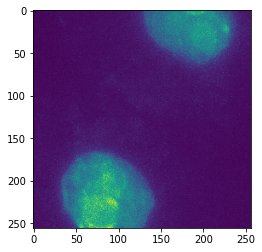

In [125]:
plt.imshow(data[50])

Done

Rearrange from 0 to 1 

In [103]:
minimum_value = data.min().min()
maximum_value = data.max().max()
range_values = maximum_value-minimum_value

In [104]:
scaler = MinMaxScaler()

In [105]:
scaler.fit(data)

MinMaxScaler()

In [106]:
data = scaler.transform(data)

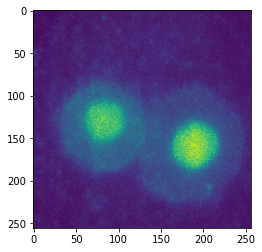

In [113]:
plt.imshow(data)

IndexError: list index out of range

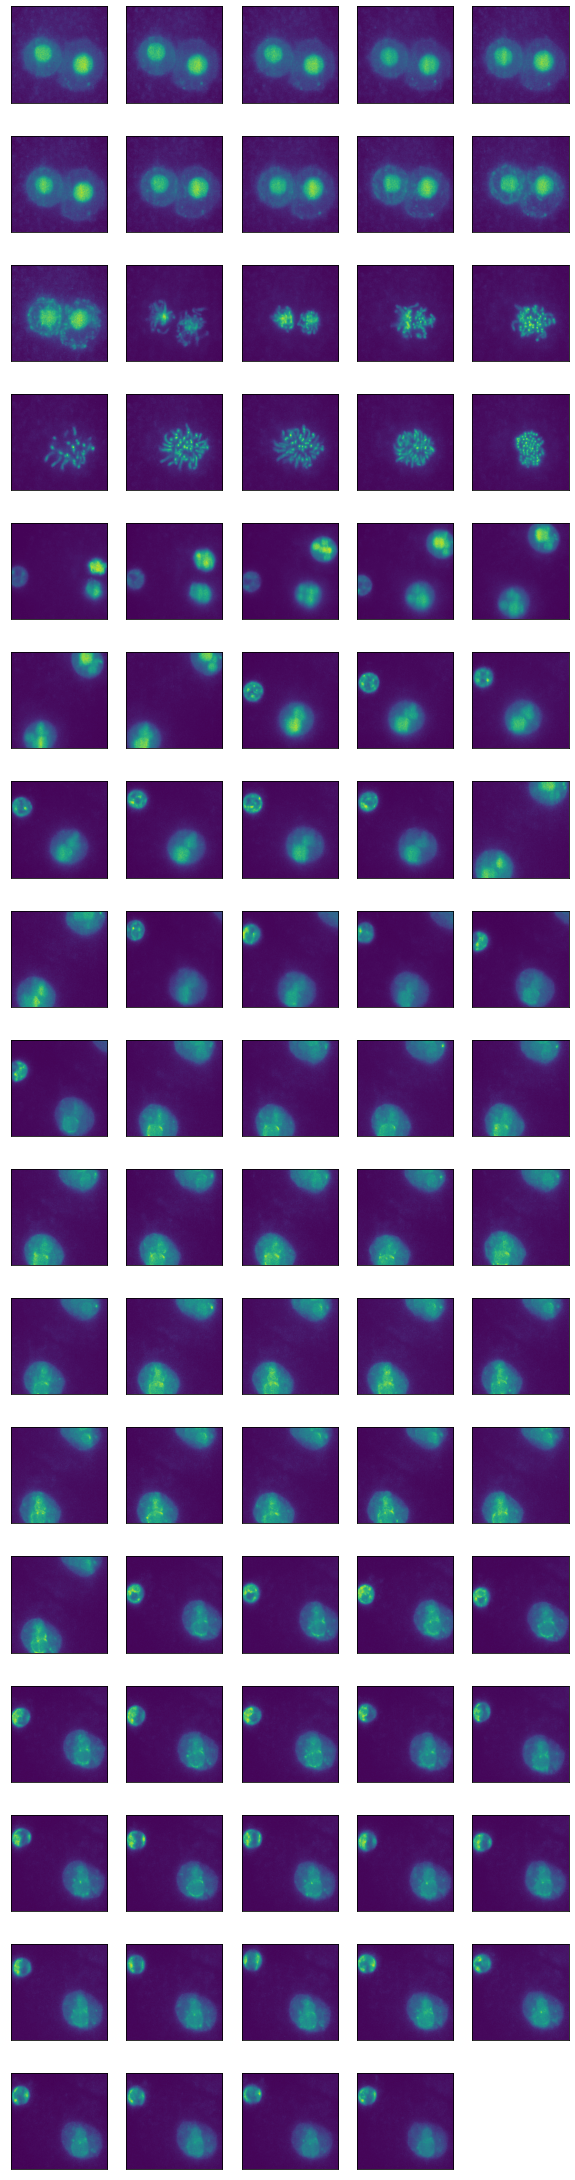

In [156]:
fig = plt.figure(figsize=(10, 40))
columns = 5
rows = 17
for i in range(1, columns*rows +1):
    img = data[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [3]:
image_data = []
for i in range(85):
    img = pd.read_csv(f'csv/embryo_1_{i}')
    img = img.iloc[: , 1:]
    image_data.append(img)